In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.feature_selection import RFE

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import plot_confusion_matrix

import delayed
from imblearn.over_sampling import SMOTE

import random
import itertools

import scipy

In [34]:
df = pd.read_csv("data.csv")
df.shape

(6819, 96)

In [35]:
df.head()
#df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [36]:
#looking for possibly categorical features
Filter = []

for col in df.columns:
    if df[col].nunique()<300:
        Filter.append(True)
    else:
        Filter.append(False)

categorical_c = df.loc[:,Filter] #we are filtering columns in this case

print(df.loc[:,Filter])

df = df.drop([' Liability-Assets Flag',' Net Income Flag'], 1)

      Bankrupt?   Liability-Assets Flag   Net Income Flag
0             1                       0                 1
1             1                       0                 1
2             1                       0                 1
3             1                       0                 1
4             1                       0                 1
...         ...                     ...               ...
6814          0                       0                 1
6815          0                       0                 1
6816          0                       0                 1
6817          0                       0                 1
6818          0                       0                 1

[6819 rows x 3 columns]


It turns out that only two features are categorical (Liability-Assets Flag, Liability-Assets Flag) and they also happen to be useless because of all datapoints having the same value. All other features are numerical and some of them are normalized between (0,1) but not all of them. Their standard deviations vary as well.

0    6599
1     220
Name: Bankrupt?, dtype: int64
Total percentage of bankrupted companies is 3.2 %.


D:\Anaconda2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


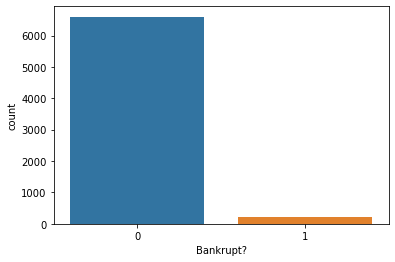

In [37]:
#analyzing Target variable (Class: 0 = Not Bankrupt, 1 = Bankrupt)

print(df["Bankrupt?"].value_counts())
percentage = df["Bankrupt?"].value_counts()[1]/len(df)
print("Total percentage of bankrupted companies is %.1f" %(percentage*100) + " %.")
sns.countplot(df["Bankrupt?"])
plt.show()

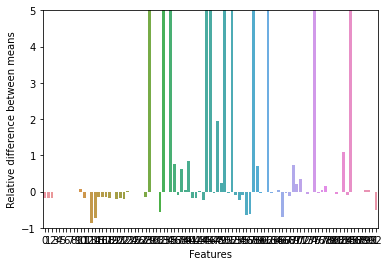

In [38]:
#Variables' effect on class

features = df.columns[1:] #from now on "features" are interchangable with "columns"
X = df[features]
y = df["Bankrupt?"]

X_0 = X.loc[y==0,:] #not bankrupted
X_1 = X.loc[y==1,:] #bakrupted

X_0_test = X_0.sample(n=220)

significant_cols = [] #features that have different means
difs=[] #differences between means

for col in X.columns:
    relative_means_difference = (X_1[col].mean() - X_0_test[col].mean()) / X_0_test[col].mean() 
    difs.append([col,relative_means_difference])
    if abs(relative_means_difference)>0.5: #tresnhold, at least 50% greater/smaller mean 
        significant_cols.append(col)


sns.barplot(x=list(range(len(difs))),y=[e[1] for e in difs])
plt.ylim((-1,5))
plt.xlabel("Features")
plt.ylabel("Relative difference between means")
plt.show()

#print(len(significant_cols))

This is no statisctical test! I only wanted glance at the data to see on whether there is an obvious difference between companies that bakrupted and that did not. So I create two datasets X_1, X_0. There are a few features with really big differences and overall around 20 features whose means are more than 50% apart in these two categories.

note: from now on I call features all the predictor variables (columns) except for the target variable

note: due to the different ranges of data for each column, the chart is difficult to read, use <code>plt.ylim</code> to view it more closesly if needed

MONTE CARLO hypothesis test

HYPOTHESIS: Companies that bankrupt are different than compaines that do not

p-value for each feature: percentage of sample means that are more extreme than the bankrupt companies mean

In [115]:
#MONTE CARLO HYPOTESIS TESTING

from statistics import mean

sampling_distribution = {feature: [] for feature in features} #SAMPLING DISTRIBUTION OF SAMPLE MEANS for each feature (all companies)
bankrupt_means = {feature: X_1[feature].mean() for feature in features} #MEAN of each feature (bankrupt companies)

for i in range(1000): #sampling from the data 1000 times
    X_sample = X.sample(n=220) #n same as the number of bankrupt companies, note: sampling from X
    for feature in features:
        s_mean = X_sample[feature].mean()
        sampling_distribution[feature].append(s_mean)

pvalues = {feature: None for feature in features}

def get_p_value(sampling_distribution, observed):
    l = abs(observed-mean(sampling_distribution)) #distance of observed from the sample mean
    return sum(abs(sample_mean-mean(sampling_distribution))>l for sample_mean in sampling_distribution)/len(sampling_distribution) #the proportion of data more extreme than observed
               
for feature in pvalues: #filling the pvalues dictionary
    pvalues[feature] = get_p_value(sampling_distribution[feature],bankrupt_means[feature]) 

In [9]:
print("Number of significantly different features: %d" %sum(np.array(list(pvalues.values()))>0.05))

Number of significantly different features: 31


In [10]:
dict(itertools.islice(pvalues.items(),15)) #look at the first 15 features and associated p-values

{' ROA(C) before interest and depreciation before interest': 0.0,
 ' ROA(A) before interest and % after tax': 0.0,
 ' ROA(B) before interest and depreciation after tax': 0.0,
 ' Operating Gross Margin': 0.0,
 ' Realized Sales Gross Margin': 0.0,
 ' Operating Profit Rate': 0.983,
 ' Pre-tax net Interest Rate': 0.108,
 ' After-tax net Interest Rate': 0.095,
 ' Non-industry income and expenditure/revenue': 0.12,
 ' Continuous interest rate (after tax)': 0.095,
 ' Operating Expense Rate': 0.63,
 ' Research and development expense rate': 0.044,
 ' Cash flow rate': 0.0,
 ' Interest-bearing debt interest rate': 0.047,
 ' Tax rate (A)': 0.0}

Most of the features are signicantly different between the two categories. Some features are less different and some show no difference whatsoever. However, I only exaimined the variables independently while there are probably many dependencies between them so I am not gonna draw conclusions or perform feature selection based on these p-values.

D:\Anaconda2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

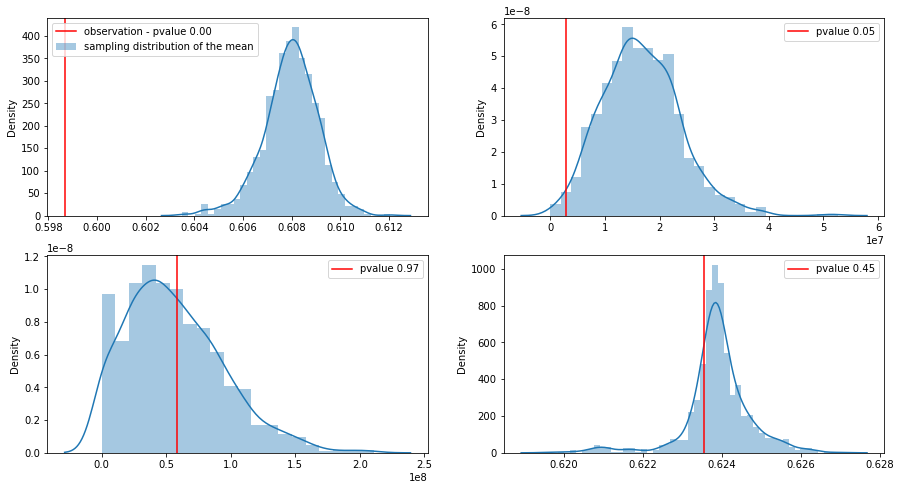

In [11]:
#Plotting some features and their distribution of sample means + red line with the mean of the observed data (= data of bankrupt companies)

fig, axes = plt.subplots(2,2, figsize=(15,8))

sns.distplot(sampling_distribution[" Operating Gross Margin"], ax=axes[0,0],label="sampling distribution of the mean")
axes[0,0].axvline(x=bankrupt_means[" Operating Gross Margin"],label="observation - pvalue %.2f"%pvalues[" Operating Gross Margin"],c="r")
axes[0,0].legend(loc='upper left')

sns.distplot(sampling_distribution[" Interest-bearing debt interest rate"], ax=axes[0,1])
axes[0,1].axvline(x=bankrupt_means[" Interest-bearing debt interest rate"],label="pvalue %.2f"%pvalues[" Interest-bearing debt interest rate"],c="r")
axes[0,1].legend()

sns.distplot(sampling_distribution[" Inventory/Current Liability"], ax=axes[1,0])
axes[1,0].axvline(x=bankrupt_means[" Inventory/Current Liability"],label="pvalue %.2f"%pvalues[" Inventory/Current Liability"],c="r")
axes[1,0].legend()

sns.distplot(sampling_distribution[" No-credit Interval"], ax=axes[1,1])
axes[1,1].axvline(x=bankrupt_means[" No-credit Interval"],label="pvalue %.2f"%pvalues[" No-credit Interval"],c="r")
axes[1,1].legend()

plt.legend()
plt.show()

D:\Anaconda2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


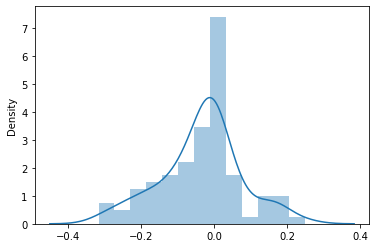

In [12]:
#Correlation with the target variable

Xy_data = pd.concat([y,X],axis=1)

correlations = []

for feature in Xy_data.columns[1:]:
    correlations.append(Xy_data["Bankrupt?"].corr(Xy_data[feature]))

sns.distplot(correlations)
plt.show()

There are no features with strong correlation with the target variable, there is rather small or no correlation.

In [9]:
#MULTICOLLINEARITY

cor_matrix = df.corr().abs()
cor_matrix.style.background_gradient(sns.light_palette('red', as_cmap=True))

In [39]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

dropped_cols = set()
for feature in upper_tri.columns:
    if any(upper_tri[feature] > 0.9):
        dropped_cols.add(feature)

print("There are %d dropped columns" %len(dropped_cols))

X = X.drop(dropped_cols,axis=1)
X.head()

There are 19 dropped columns


,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),...,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.370594,0.601457,0.998969,0.302646,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,...,0.458609,0.520382,0.312905,0.118250,0.009219,0.622879,0.827890,0.026601,0.564050,0.016469
1,0.464291,0.610235,0.998946,0.303556,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,...,0.459001,0.567101,0.314163,0.047775,0.008323,0.623652,0.839969,0.264577,0.570175,0.020794
2,0.426071,0.601450,0.998857,0.302035,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,...,0.459254,0.538491,0.314515,0.025346,0.040003,0.623841,0.836774,0.026555,0.563706,0.016474
3,0.399844,0.583541,0.998700,0.303350,1.078888e-04,0.0,0.465705,0.000449,0.0,0.154187,...,0.448518,0.604105,0.302382,0.067250,0.003252,0.622929,0.834697,0.026697,0.564663,0.023982
4,0.465022,0.598783,0.998973,0.303475,7.890000e+09,0.0,0.462746,0.000686,0.0,0.167502,...,0.454411,0.578469,0.311567,0.047725,0.003878,0.623521,0.839973,0.024752,0.575617,0.035490


In [23]:
#CORRELATION BETWEEN PREDICTOR VARIABLES

#PCA
scaler = StandardScaler()
X_for_pca = pd.DataFrame(data=scaler.fit_transform(X),index=X.index,columns=X.columns) #standardized dataset

n_components = 10

pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X)
X_pc = pd.DataFrame(data=principal_components, columns=['PC %d'%d for d in range(n_components)])

print("Explained variance by 10 components %.2f" %sum(pca.explained_variance_ratio_))

Explained variance by 10 components 0.42


In [17]:
#DATA IMBALANCE

#SMOTE

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts()


Balance of positive and negative classes (%):


1    6599
0    6599
Name: Bankrupt?, dtype: int64

In [41]:
def train_test_SVM(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=30, stratify=y) #stratify adresses the unbalance only in the train test splitting
    sw_train = class_weight.compute_sample_weight(class_weight = 'balanced', y = y_train) #when balanced sw_train = [1.1.1...1]
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(cache_size=7000))]
    pipeline = Pipeline(steps)
    
    param_grid = {
    'SVM__C':[0.01,0.1,1,10,100],
    'SVM__gamma':[0.1,0.01,0.001,0.0001,0.00001],
    'SVM__kernel':['rbf']
    }
    
    f1 = make_scorer(f1_score , average='macro')
    grid = GridSearchCV(pipeline,param_grid=param_grid, cv=5, scoring=f1)
    grid.fit(X_train, y_train, SVM__sample_weight = sw_train)
    
    print("best parameters: ")
    print(grid.best_params_)
    
    model = grid.best_estimator_
    y_pred = model.predict(X_test)
    print("The f1 score is %.2f "%f1_score(y_test, y_pred))
    print("Precision: %.2f" %precision_score(y_test, y_pred))
    print("Recall: %.2f" %recall_score(y_test, y_pred))
    print("Precision: %.2f" %precision_score(y_test, y_pred))
    plot_confusion_matrix(model,
                         X_test,
                         y_test,
                         values_format='d')
    return model

[1. 1. 1. ... 1. 1. 1.]
best parameters: 
{'SVM__C': 10, 'SVM__gamma': 0.1, 'SVM__kernel': 'rbf'}
The f1 score is 0.99 
Precision: 0.98
Recall: 0.99
Precision: 0.98


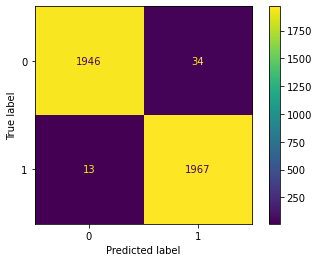

In [42]:
model = train_test_SVM(X_sm,y_sm)

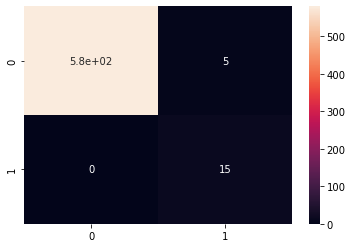

In [31]:
"""
test_sample_indices = random.sample(range(0,len(X)), 600)

X_sample = X.iloc[test_sample_indices,:]
y_sample = y.iloc[test_sample_indices]

y_pred = model.predict(X_sample)
cf_matrix = confusion_matrix(y_sample, y_pred)
sns.heatmap(cf_matrix, annot=True)
"""

[0.51667027 0.51667027 0.51667027 ... 0.51667027 0.51667027 0.51667027]
The f1 score is 0.31 


Pipeline(steps=[('scaler', StandardScaler()), ('SVM', SVC(C=1, gamma=1e-05))])

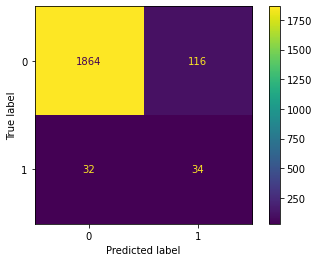

In [15]:
#Training and testing without SMOTE

#train_test_SVM(X,y)

In [ ]:
#FEATURE SELECTION 

rfe_selector = RFE(estimator=Pipeline([('scaler', StandardScaler()), ('SVM', SVC(cache_size=7000))]),features_to_select=30, step=5, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

NOTES:

run one by one